In [1]:
pip install pystan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import pandas as pd
import stan
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from numpy import random
from scipy.stats import norm
import nest_asyncio

In [ ]:
sns.set_style("whitegrid")  # Set the style directly using seaborn
#sns.set(font="Times New Roman")  # Set the font using seaborn

plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=20)

In [ ]:
np.random.seed(101)
pi=3.141592653589794
ActualRunTime = 8256*3600
Runtime = 1000
N_L = 900
N_T = 100
num_PionDet = 28
num_MainDet = 84

In [ ]:
#Rates values from simulations at
#/home/elhamm/projects/def-wdconinc/elhamm/PionDetectorOptimization/simulation/run/remoll-Updated-July2023/Moller_Asymmetry/MainDet
#/home/elhamm/projects/def-wdconinc/elhamm/PionDetectorOptimization/simulation/run/remoll-Updated-July2023/Pion_Asymmetry/PionDet

I_Pion = 65  # Current (Micro-A [GHz])
#Rate_Mollers_PionDet = 3.5428*1e6
Rate_Mollers_PionDet = 8.54726*1e9
#Rate_Pions_PionDet = 1.71955*1e5
Rate_Pions_PionDet = 9.22396*1e10
Rates_PionDet = Rate_Pions_PionDet + Rate_Mollers_PionDet
Total_Rates_PionDet = (Rates_PionDet/(50*85*28))*65
Uncertainty_total_PionDet= (1/np.sqrt(Total_Rates_PionDet*Runtime))*1e9
Uncertainty_L_PionDet = (1/np.sqrt(Total_Rates_PionDet*Runtime*0.9))*1e9
Uncertainty_T_PionDet = (1/np.sqrt(Total_Rates_PionDet*Runtime*0.1))*1e9

#Rate_Mollers_MainDet = 2.77266*1e8
Rate_Mollers_MainDet = 1.3573441*1e14
#Rate_Pions_MainDet = 2.27860*1e6
Rate_Pions_MainDet =1.1465975*1e11
Rates_MainDet = Rate_Pions_MainDet + Rate_Mollers_MainDet
Total_Rates_MainDet = (Rates_MainDet/(50*84))
Uncertainty_total_MainDet= (1/np.sqrt(Total_Rates_MainDet*Runtime))*1e9
Uncertainty_L_MainDet = (1/np.sqrt(Total_Rates_MainDet*Runtime*0.9))*1e9
Uncertainty_T_MainDet = (1/np.sqrt(Total_Rates_MainDet*Runtime*0.1))*1e9

print(Total_Rates_PionDet, Total_Rates_MainDet, Uncertainty_L_PionDet, Uncertainty_L_MainDet, Uncertainty_T_PionDet, Uncertainty_T_MainDet, Uncertainty_total_PionDet, Uncertainty_total_MainDet)


55051646.2184874 32345016607.142857 4492.556939445852 185.34251678337282 13477.670818337554 556.0275503501185 4262.013733993213 175.83135009103287


In [ ]:
Pion_Asy_L_PionDet = pd.read_csv('Pion_Asymmetry_Longitudinal_PionDet.csv')
Pion_Asy_TV_PionDet = pd.read_csv('Pion_Asymmetry_Transverse_Vertical_PionDet.csv')
Pion_Asy_TH_PionDet = pd.read_csv('Pion_Asymmetry_Transverse_Horizontal_PionDet.csv')

Pion_Asy_L_MainDet = pd.read_csv('Pion_Asymmetry-longitudinal-MainDet-Ring5.csv')
Pion_Asy_TV_MainDet = pd.read_csv('Pion_Asymmetry-transverse-vertical-MainDet-Ring5.csv')
Pion_Asy_TH_MainDet = pd.read_csv('Pion_Asymmetry-transverse-horizontal-MainDet-Ring5.csv')

Moller_Asy_L_PionDet = pd.read_csv('Moller_Asymmetry_Longitudinal_PionDet.csv')
Moller_Asy_TV_PionDet = pd.read_csv('Moller_Asymmetry-transverse-vertical-PionDet.csv')
Moller_Asy_TH_PionDet = pd.read_csv('Moller_Asymmetry-transverse-horizontal-PionDet.csv')

Moller_Asy_L_MainDet = pd.read_csv('Moller_Asymmetry-longitudinal-MainDet-Ring5.csv')
Moller_Asy_TV_MainDet = pd.read_csv('Moller_Asymmetry-transverse-vertical-MainDet-Ring5.csv')
Moller_Asy_TH_MainDet = pd.read_csv('Moller_Asymmetry-transverse-horizontal-MainDet-Ring5.csv')

Dilution_Factor_PionDet = pd.read_csv('Dilution Factor_PionDet.csv')
Dilution_Factor_MainDet = pd.read_csv('Dilution Factor_MainDet.csv')

#print(Dilution_Factor_MainDet)

In [ ]:
#Generating Mock Data - Longitudinal
Measured_Asymmetry_L_PionDet_average_values = []
Measured_Asymmetry_L_PionDet_standard_deviations = []
Measured_Asymmetry_L_MainDet_average_values = []
Measured_Asymmetry_L_MainDet_standard_deviations = []
Measured_Asymmetry_L_PionDet = np.zeros((num_PionDet, N_L))
Measured_Asymmetry_L_MainDet = np.zeros((num_MainDet, N_L))

Measured_Asymmetry_L_PionDet_average_values_True = []
Measured_Asymmetry_L_PionDet_standard_deviations_True = []
Measured_Asymmetry_L_MainDet_average_values_True = []
Measured_Asymmetry_L_MainDet_standard_deviations_True = []
Measured_Asymmetry_L_PionDet_True = np.zeros((num_PionDet, N_L))
Measured_Asymmetry_L_MainDet_True = np.zeros((num_MainDet, N_L))

for iteration in range(N_L):
  Pion_Asymmetry_L_PionDet = []
  Moller_Asymmetry_L_PionDet = []
  dAsymmetry_L_PionDet = []
  Pion_Asymmetry_TV_PionDet = []
  Pion_Asymmetry_TH_PionDet =[]
  Moller_Asymmetry_TV_PionDet = []
  Moller_Asymmetry_TH_PionDet =[]
  f_Pi_PionDet = []

  Pion_Asymmetry_L_MainDet = []
  Moller_Asymmetry_L_MainDet = []
  dAsymmetry_L_MainDet = []
  Pion_Asymmetry_TV_MainDet = []
  Pion_Asymmetry_TH_MainDet =[]
  Moller_Asymmetry_TV_MainDet = []
  Moller_Asymmetry_TH_MainDet =[]
  f_Pi_MainDet = []

  Pion_Asymmetry_L_PionDet_True = []
  Moller_Asymmetry_L_PionDet_True = []
  Pion_Asymmetry_TV_PionDet_True = []
  Pion_Asymmetry_TH_PionDet_True =[]
  Moller_Asymmetry_TV_PionDet_True = []
  Moller_Asymmetry_TH_PionDet_True =[]
  Measured_f_Pi_PionDet_True = []

  Pion_Asymmetry_L_MainDet_True = []
  Moller_Asymmetry_L_MainDet_True = []
  Pion_Asymmetry_TV_MainDet_True = []
  Pion_Asymmetry_TH_MainDet_True =[]
  Moller_Asymmetry_TV_MainDet_True = []
  Moller_Asymmetry_TH_MainDet_True =[]
  Measured_f_Pi_MainDet_True = []

  theta_L = np.random.normal(0, .0040)
  #while theta_L <= 0:
        #theta_L = np.random.normal(0, .0040)
  phi_L = np.random.normal(0, pi)

  for i in range(num_PionDet):
     Pion_Asymmetry_L_PionDet_value = np.random.normal(Pion_Asy_L_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_PionDet)
     Pion_Asymmetry_L_PionDet.append(Pion_Asymmetry_L_PionDet_value)
     Moller_Asymmetry_L_PionDet_value = np.random.normal(Moller_Asy_L_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_PionDet)
     Moller_Asymmetry_L_PionDet.append(Moller_Asymmetry_L_PionDet_value)
     Pion_Asymmetry_TV_PionDet_value = np.random.normal(Pion_Asy_TV_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_PionDet)
     Pion_Asymmetry_TV_PionDet.append(Pion_Asymmetry_TV_PionDet_value)
     Pion_Asymmetry_TH_PionDet_value = np.random.normal(Pion_Asy_TH_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_PionDet)
     Pion_Asymmetry_TH_PionDet.append(Pion_Asymmetry_TH_PionDet_value)
     Moller_Asymmetry_TV_PionDet_value = np.random.normal(Moller_Asy_TV_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_PionDet)
     Moller_Asymmetry_TV_PionDet.append(Moller_Asymmetry_TV_PionDet_value)
     Moller_Asymmetry_TH_PionDet_value = np.random.normal(Moller_Asy_TH_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_PionDet)
     Moller_Asymmetry_TH_PionDet.append(Moller_Asymmetry_TH_PionDet_value)
     f_Pi_PionDet_value = np.random.normal(Dilution_Factor_PionDet.at[i, 'Ratio'], Dilution_Factor_PionDet.at[i, 'Ratio_Uncertainty'])
     f_Pi_PionDet.append(f_Pi_PionDet_value)

     Pion_Asymmetry_L_PionDet_True_value = (Pion_Asy_L_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_L_PionDet_True.append(Pion_Asymmetry_L_PionDet_True_value)
     Moller_Asymmetry_L_PionDet_True_value = (Moller_Asy_L_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_L_PionDet_True.append(Moller_Asymmetry_L_PionDet_True_value)
     Pion_Asymmetry_TV_PionDet_True_value = (Pion_Asy_TV_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TV_PionDet_True.append(Pion_Asymmetry_TV_PionDet_True_value)
     Pion_Asymmetry_TH_PionDet_True_value = (Pion_Asy_TH_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TH_PionDet_True.append(Pion_Asymmetry_TH_PionDet_True_value)
     Moller_Asymmetry_TV_PionDet_True_value = (Moller_Asy_TV_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TV_PionDet_True.append(Moller_Asymmetry_TV_PionDet_True_value)
     Moller_Asymmetry_TH_PionDet_True_value = (Moller_Asy_TH_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TH_PionDet_True.append(Moller_Asymmetry_TH_PionDet_True_value)
     f_Pi_PionDet_True_value = (Dilution_Factor_PionDet.at[i, 'Ratio'])
     Measured_f_Pi_PionDet_True.append(f_Pi_PionDet_True_value)

  # Convert the entire list to a numpy array
  A_piL_PionDet = np.array(Pion_Asymmetry_L_PionDet)
  A_eL_PionDet = np.array(Moller_Asymmetry_L_PionDet)
  A_piTV_PionDet = np.array(Pion_Asymmetry_TV_PionDet)
  A_eTV_PionDet = np.array(Moller_Asymmetry_TV_PionDet)
  A_piTH_PionDet = np.array(Pion_Asymmetry_TH_PionDet)
  A_eTH_PionDet = np.array(Moller_Asymmetry_TH_PionDet)
  f_Pi_PionDet = np.array(f_Pi_PionDet)

  A_eL_PionDet_True = np.array(Moller_Asymmetry_L_PionDet_True)
  A_eTV_PionDet_True = np.array(Moller_Asymmetry_TV_PionDet_True)
  A_eTH_PionDet_True = np.array(Moller_Asymmetry_TH_PionDet_True)
  A_piL_PionDet_True = np.array(Pion_Asymmetry_L_PionDet_True)
  A_piTV_PionDet_True = np.array(Pion_Asymmetry_TV_PionDet_True)
  A_piTH_PionDet_True = np.array(Pion_Asymmetry_TH_PionDet_True)
  f_Pi_PionDet_True = np.array(Measured_f_Pi_PionDet_True)


  for i in range(num_PionDet):
     Measured_Asymmetry_L_PionDet_value = (1 - f_Pi_PionDet[i]) * (A_eL_PionDet[i] * np.cos(theta_L) + np.sin(theta_L) * (A_eTV_PionDet[i]*np.sin(phi_L) + A_eTH_PionDet[i]*np.cos(phi_L))) + f_Pi_PionDet[i] * (A_piL_PionDet[i] * np.cos(theta_L) + np.sin(theta_L) * (A_piTV_PionDet[i]*np.sin(phi_L) + A_piTH_PionDet[i]*np.cos(phi_L)))
     Measured_Asymmetry_L_PionDet[i, iteration] = Measured_Asymmetry_L_PionDet_value
     Measured_Asymmetry_L_PionDet_value_True = (1 - f_Pi_PionDet_True[i]) * (A_eL_PionDet_True[i] * np.cos(theta_L) + np.sin(theta_L) * (A_eTV_PionDet_True[i]*np.sin(phi_L) + A_eTH_PionDet_True[i]*np.cos(phi_L))) + f_Pi_PionDet_True[i] * (A_piL_PionDet_True[i] * np.cos(theta_L) + np.sin(theta_L) * (A_piTV_PionDet_True[i]*np.sin(phi_L) + A_piTH_PionDet_True[i]*np.cos(phi_L)))
     Measured_Asymmetry_L_PionDet_True[i, iteration] = Measured_Asymmetry_L_PionDet_value_True

  for i in range(num_MainDet):
     Pion_Asymmetry_L_MainDet_value = np.random.normal(Pion_Asy_L_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_MainDet)
     Pion_Asymmetry_L_MainDet.append(Pion_Asymmetry_L_MainDet_value)
     Moller_Asymmetry_L_MainDet_value = np.random.normal(Moller_Asy_L_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_MainDet)
     Moller_Asymmetry_L_MainDet.append(Moller_Asymmetry_L_MainDet_value)
     Pion_Asymmetry_TV_MainDet_value = np.random.normal(Pion_Asy_TV_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_MainDet)
     Pion_Asymmetry_TV_MainDet.append(Pion_Asymmetry_TV_MainDet_value)
     Pion_Asymmetry_TH_MainDet_value = np.random.normal(Pion_Asy_TH_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_L_MainDet)
     Pion_Asymmetry_TH_MainDet.append(Pion_Asymmetry_TH_MainDet_value)
     Moller_Asymmetry_TV_MainDet_value = np.random.normal(Moller_Asy_TV_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_MainDet)
     Moller_Asymmetry_TV_MainDet.append(Moller_Asymmetry_TV_MainDet_value)
     Moller_Asymmetry_TH_MainDet_value = np.random.normal(Moller_Asy_TH_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_L_MainDet)
     Moller_Asymmetry_TH_MainDet.append(Moller_Asymmetry_TH_MainDet_value)
     f_Pi_MainDet_value = np.random.normal(Dilution_Factor_MainDet.at[i, 'Ratio'], Dilution_Factor_MainDet.at[i, 'Ratio_Uncertainty'])
     f_Pi_MainDet.append(f_Pi_MainDet_value)

     Pion_Asymmetry_L_MainDet_True_value = (Pion_Asy_L_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_L_MainDet_True.append(Pion_Asymmetry_L_MainDet_True_value)
     Moller_Asymmetry_L_MainDet_True_value = (Moller_Asy_L_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_L_MainDet_True.append(Moller_Asymmetry_L_MainDet_True_value)
     Pion_Asymmetry_TV_MainDet_True_value = (Pion_Asy_TV_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TV_MainDet_True.append(Pion_Asymmetry_TV_MainDet_True_value)
     Pion_Asymmetry_TH_MainDet_True_value = (Pion_Asy_TH_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TH_MainDet_True.append(Pion_Asymmetry_TH_MainDet_True_value)
     Moller_Asymmetry_TV_MainDet_True_value = (Moller_Asy_TV_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TV_MainDet_True.append(Moller_Asymmetry_TV_MainDet_True_value)
     Moller_Asymmetry_TH_MainDet_True_value = (Moller_Asy_TH_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TH_MainDet_True.append(Moller_Asymmetry_TH_MainDet_True_value)
     f_Pi_MainDet_True_value = (Dilution_Factor_MainDet.at[i, 'Ratio'])
     Measured_f_Pi_MainDet_True.append(f_Pi_MainDet_True_value)

  # Convert the entire list to a numpy array
  A_piL_MainDet = np.array(Pion_Asymmetry_L_MainDet)
  A_eL_MainDet = np.array(Moller_Asymmetry_L_MainDet)
  A_piTV_MainDet = np.array(Pion_Asymmetry_TV_MainDet)
  A_eTV_MainDet = np.array(Moller_Asymmetry_TV_MainDet)
  A_piTH_MainDet = np.array(Pion_Asymmetry_TH_MainDet)
  A_eTH_MainDet = np.array(Moller_Asymmetry_TH_MainDet)
  f_Pi_MainDet = np.array(f_Pi_MainDet)

  A_eL_MainDet_True = np.array(Moller_Asymmetry_L_MainDet_True)
  A_eTV_MainDet_True = np.array(Moller_Asymmetry_TV_MainDet_True)
  A_eTH_MainDet_True = np.array(Moller_Asymmetry_TH_MainDet_True)
  A_piL_MainDet_True = np.array(Pion_Asymmetry_L_MainDet_True)
  A_piTV_MainDet_True = np.array(Pion_Asymmetry_TV_MainDet_True)
  A_piTH_MainDet_True = np.array(Pion_Asymmetry_TH_MainDet_True)
  f_Pi_MainDet_True = np.array(Measured_f_Pi_MainDet_True)

  for i in range(num_MainDet):
     Measured_Asymmetry_L_MainDet_value = (1 - f_Pi_MainDet[i]) * (A_eL_MainDet[i] * np.cos(theta_L) + np.sin(theta_L) * (A_eTV_MainDet[i]*np.sin(phi_L) + A_eTH_MainDet[i]*np.cos(phi_L))) + f_Pi_MainDet[i] * (A_piL_MainDet[i] * np.cos(theta_L) + np.sin(theta_L) * (A_piTV_MainDet[i]*np.sin(phi_L) + A_piTH_MainDet[i]*np.cos(phi_L)))
     Measured_Asymmetry_L_MainDet[i, iteration] = Measured_Asymmetry_L_MainDet_value
     Measured_Asymmetry_L_MainDet_value_True = (1 - f_Pi_MainDet_True[i]) * (A_eL_MainDet_True[i] * np.cos(theta_L) + np.sin(theta_L) * (A_eTV_MainDet_True[i]*np.sin(phi_L) + A_eTH_MainDet_True[i]*np.cos(phi_L))) + f_Pi_MainDet_True[i] * (A_piL_MainDet_True[i] * np.cos(theta_L) + np.sin(theta_L) * (A_piTV_MainDet_True[i]*np.sin(phi_L) + A_piTH_MainDet_True[i]*np.cos(phi_L)))
     Measured_Asymmetry_L_MainDet_True[i, iteration] = Measured_Asymmetry_L_MainDet_value_True

Measured_Asymmetry_L_PionDet_average_values = np.mean(Measured_Asymmetry_L_PionDet, axis=1)
Measured_Asymmetry_L_PionDet_standard_deviations = np.std(Measured_Asymmetry_L_PionDet, axis=1)
Measured_Asymmetry_L_MainDet_average_values = np.mean(Measured_Asymmetry_L_MainDet, axis=1)
Measured_Asymmetry_L_MainDet_standard_deviations = np.std(Measured_Asymmetry_L_MainDet, axis=1)

Measured_Asymmetry_L_PionDet_average_values_True = np.mean(Measured_Asymmetry_L_PionDet_True, axis=1)
Measured_Asymmetry_L_PionDet_standard_deviations_True = np.std(Measured_Asymmetry_L_PionDet_True, axis=1)
Measured_Asymmetry_L_MainDet_average_values_True = np.mean(Measured_Asymmetry_L_MainDet_True, axis=1)
Measured_Asymmetry_L_MainDet_standard_deviations_True = np.std(Measured_Asymmetry_L_MainDet_True, axis=1)

#print(Measured_Asymmetry_L_PionDet_average_values, Measured_Asymmetry_L_PionDet_average_values.shape)

#print(Measured_Asymmetry_L_MainDet_average_values, Measured_Asymmetry_L_MainDet_average_values.shape)

#print(Measured_Asymmetry_L_PionDet_average_values_True, Measured_Asymmetry_L_PionDet_average_values_True.shape)

#print(Measured_Asymmetry_L_MainDet_average_values_True, Measured_Asymmetry_L_MainDet_average_values_True.shape)

print(Measured_Asymmetry_L_PionDet_average_values.shape, Measured_Asymmetry_L_MainDet_average_values.shape, Measured_Asymmetry_L_PionDet_average_values_True.shape, Measured_Asymmetry_L_MainDet_average_values_True.shape)


(28,) (84,) (28,) (84,)


In [ ]:
#DetNo = list(range(1, 85))

#plt.figure(figsize=(16,6))

#plt.plot(DetNo, Pion_Asymmetry_TH_MainDet_True, 'o-')
#plt.xlabel('DetNo')
#plt.grid(True)
#plt.show()

In [ ]:
# Create a DataFrame
df_PionDet_L = pd.DataFrame(Measured_Asymmetry_L_PionDet_average_values, columns=['Asymmetry_PionDet'])
df_MainDet_L = pd.DataFrame(Measured_Asymmetry_L_MainDet_average_values, columns=['Asymmetry_MainDet'])
# Save the DataFrame to a .csv file
df_PionDet_L.to_csv('Measured_Asymmetry_PionDet_L.csv', index=False)
df_MainDet_L.to_csv('Measured_Asymmetry_MainDet_L.csv', index=False)

print("Data saved to Measured_Asymmetry_PionDet_L.csv")
print("Data saved to Measured_Asymmetry_MainnDet_L.csv")

Data saved to Measured_Asymmetry_PionDet_L.csv
Data saved to Measured_Asymmetry_MainnDet_L.csv


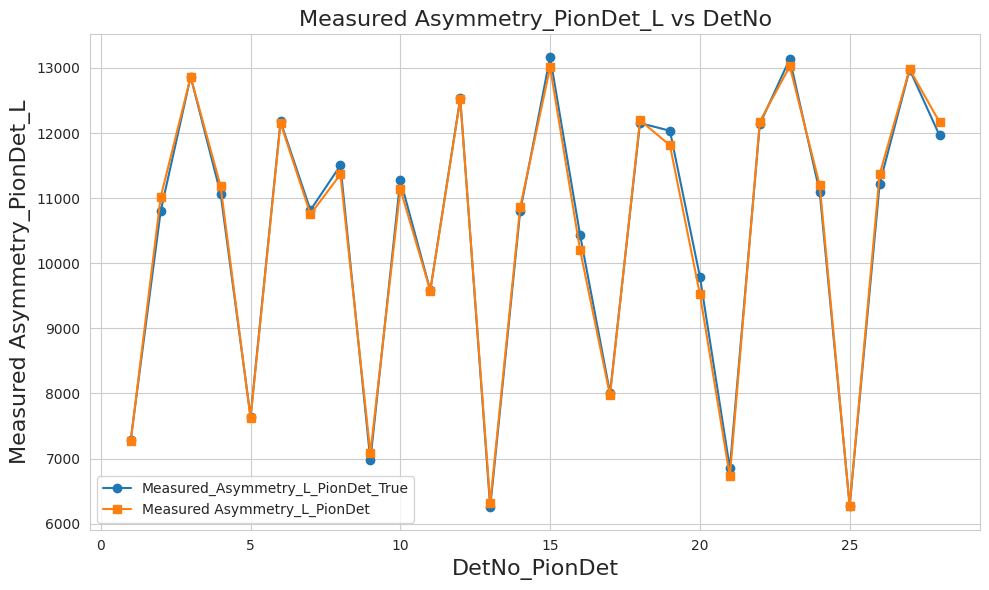

In [ ]:

DetNo_PionDet = np.arange(1, 29)  # This creates an array from 1 to 56

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_PionDet, Measured_Asymmetry_L_PionDet_average_values_True , 'o-', label='Measured_Asymmetry_L_PionDet_True')
plt.plot(DetNo_PionDet, Measured_Asymmetry_L_PionDet_average_values, 's-', label='Measured Asymmetry_L_PionDet')
plt.title('Measured Asymmetry_PionDet_L vs DetNo')
plt.xlabel('DetNo_PionDet')
plt.ylabel('Measured Asymmetry_PionDet_L')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

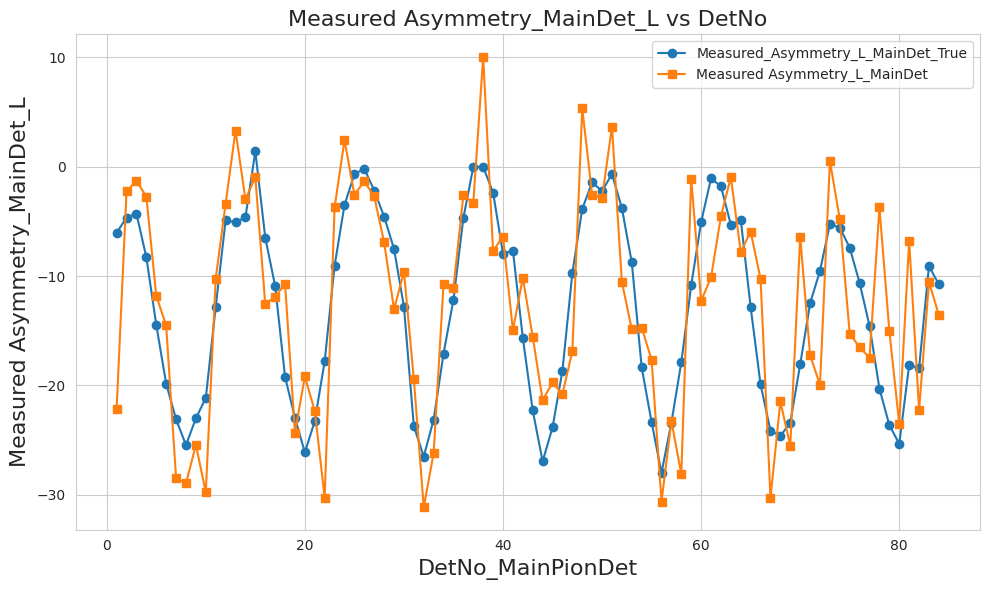

In [ ]:
DetNo_MainDet = np.arange(1, 85)  # This creates an array from 1 to 56

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_MainDet, Measured_Asymmetry_L_MainDet_average_values_True , 'o-', label='Measured_Asymmetry_L_MainDet_True')
plt.plot(DetNo_MainDet, Measured_Asymmetry_L_MainDet_average_values, 's-', label='Measured Asymmetry_L_MainDet')
plt.title('Measured Asymmetry_MainDet_L vs DetNo')
plt.xlabel('DetNo_MainPionDet')
plt.ylabel('Measured Asymmetry_MainDet_L')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Generating Mock Data - Transverse
Measured_Asymmetry_T_PionDet_average_values = []
Measured_Asymmetry_T_PionDet_standard_deviations = []
Measured_Asymmetry_T_MainDet_average_values = []
Measured_Asymmetry_T_MainDet_standard_deviations = []
Measured_Asymmetry_T_PionDet = np.zeros((num_PionDet, N_T))
Measured_Asymmetry_T_MainDet = np.zeros((num_MainDet, N_T))

Measured_Asymmetry_T_PionDet_average_values_True = []
Measured_Asymmetry_T_PionDet_standard_deviations_True = []
Measured_Asymmetry_T_MainDet_average_values_True = []
Measured_Asymmetry_T_MainDet_standard_deviations_True = []
Measured_Asymmetry_T_PionDet_True = np.zeros((num_PionDet, N_T))
Measured_Asymmetry_T_MainDet_True = np.zeros((num_MainDet, N_T))

for iteration in range(N_T):
  Pion_Asymmetry_L_PionDet = []
  Moller_Asymmetry_L_PionDet = []
  dAsymmetry_L_PionDet = []
  Pion_Asymmetry_TV_PionDet = []
  Pion_Asymmetry_TH_PionDet =[]
  Moller_Asymmetry_TV_PionDet = []
  Moller_Asymmetry_TH_PionDet =[]
  f_Pi_PionDet = []

  Pion_Asymmetry_L_MainDet = []
  Moller_Asymmetry_L_MainDet = []
  dAsymmetry_L_MainDet = []
  Pion_Asymmetry_TV_MainDet = []
  Pion_Asymmetry_TH_MainDet =[]
  Moller_Asymmetry_TV_MainDet = []
  Moller_Asymmetry_TH_MainDet =[]
  f_Pi_MainDet = []

  Pion_Asymmetry_L_PionDet_True = []
  Moller_Asymmetry_L_PionDet_True = []
  Pion_Asymmetry_TV_PionDet_True = []
  Pion_Asymmetry_TH_PionDet_True =[]
  Moller_Asymmetry_TV_PionDet_True = []
  Moller_Asymmetry_TH_PionDet_True =[]
  Measured_f_Pi_PionDet_True = []

  Pion_Asymmetry_L_MainDet_True = []
  Moller_Asymmetry_L_MainDet_True = []
  Pion_Asymmetry_TV_MainDet_True = []
  Pion_Asymmetry_TH_MainDet_True =[]
  Moller_Asymmetry_TV_MainDet_True = []
  Moller_Asymmetry_TH_MainDet_True =[]
  Measured_f_Pi_MainDet_True = []

  theta_T = np.random.normal(pi/2, .0040)
  phi_T = np.random.normal(0, pi)

  for i in range(num_PionDet):
     Pion_Asymmetry_L_PionDet_value = np.random.normal(Pion_Asy_L_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_PionDet)
     Pion_Asymmetry_L_PionDet.append(Pion_Asymmetry_L_PionDet_value)
     Moller_Asymmetry_L_PionDet_value = np.random.normal(Moller_Asy_L_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_PionDet)
     Moller_Asymmetry_L_PionDet.append(Moller_Asymmetry_L_PionDet_value)
     Pion_Asymmetry_TV_PionDet_value = np.random.normal(Pion_Asy_TV_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_PionDet)
     Pion_Asymmetry_TV_PionDet.append(Pion_Asymmetry_TV_PionDet_value)
     Pion_Asymmetry_TH_PionDet_value = np.random.normal(Pion_Asy_TH_PionDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_PionDet)
     Pion_Asymmetry_TH_PionDet.append(Pion_Asymmetry_TH_PionDet_value)
     Moller_Asymmetry_TV_PionDet_value = np.random.normal(Moller_Asy_TV_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_PionDet)
     Moller_Asymmetry_TV_PionDet.append(Moller_Asymmetry_TV_PionDet_value)
     Moller_Asymmetry_TH_PionDet_value = np.random.normal(Moller_Asy_TH_PionDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_PionDet)
     Moller_Asymmetry_TH_PionDet.append(Moller_Asymmetry_TH_PionDet_value)
     f_Pi_PionDet_value = np.random.normal(Dilution_Factor_PionDet.at[i, 'Ratio'], Dilution_Factor_PionDet.at[i, 'Ratio_Uncertainty'])
     f_Pi_PionDet.append(f_Pi_PionDet_value)

     Pion_Asymmetry_L_PionDet_True_value = (Pion_Asy_L_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_L_PionDet_True.append(Pion_Asymmetry_L_PionDet_True_value)
     Moller_Asymmetry_L_PionDet_True_value = (Moller_Asy_L_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_L_PionDet_True.append(Moller_Asymmetry_L_PionDet_True_value)
     Pion_Asymmetry_TV_PionDet_True_value = (Pion_Asy_TV_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TV_PionDet_True.append(Pion_Asymmetry_TV_PionDet_True_value)
     Pion_Asymmetry_TH_PionDet_True_value = (Pion_Asy_TH_PionDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TH_PionDet_True.append(Pion_Asymmetry_TH_PionDet_True_value)
     Moller_Asymmetry_TV_PionDet_True_value = (Moller_Asy_TV_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TV_PionDet_True.append(Moller_Asymmetry_TV_PionDet_True_value)
     Moller_Asymmetry_TH_PionDet_True_value = (Moller_Asy_TH_PionDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TH_PionDet_True.append(Moller_Asymmetry_TH_PionDet_True_value)
     f_Pi_PionDet_True_value = (Dilution_Factor_PionDet.at[i, 'Ratio'])
     Measured_f_Pi_PionDet_True.append(f_Pi_PionDet_True_value)

  # Convert the entire list to a numpy array
  A_piL_PionDet = np.array(Pion_Asymmetry_L_PionDet)
  A_eL_PionDet = np.array(Moller_Asymmetry_L_PionDet)
  A_piTV_PionDet = np.array(Pion_Asymmetry_TV_PionDet)
  A_eTV_PionDet = np.array(Moller_Asymmetry_TV_PionDet)
  A_piTH_PionDet = np.array(Pion_Asymmetry_TH_PionDet)
  A_eTH_PionDet = np.array(Moller_Asymmetry_TH_PionDet)
  f_Pi_PionDet = np.array(f_Pi_PionDet)

  A_eL_PionDet_True = np.array(Moller_Asymmetry_L_PionDet_True)
  A_eTV_PionDet_True = np.array(Moller_Asymmetry_TV_PionDet_True)
  A_eTH_PionDet_True = np.array(Moller_Asymmetry_TH_PionDet_True)
  A_piL_PionDet_True = np.array(Pion_Asymmetry_L_PionDet_True)
  A_piTV_PionDet_True = np.array(Pion_Asymmetry_TV_PionDet_True)
  A_piTH_PionDet_True = np.array(Pion_Asymmetry_TH_PionDet_True)
  f_Pi_PionDet_True = np.array(Measured_f_Pi_PionDet_True)


  for i in range(num_PionDet):
     Measured_Asymmetry_T_PionDet_value = (1 - f_Pi_PionDet[i]) * (A_eL_PionDet[i] * np.cos(theta_T) + np.sin(theta_T) * (A_eTV_PionDet[i]*np.sin(phi_T) + A_eTH_PionDet[i]*np.cos(phi_T))) + f_Pi_PionDet[i] * (A_piL_PionDet[i] * np.cos(theta_T) + np.sin(theta_T) * (A_piTV_PionDet[i]*np.sin(phi_T) + A_piTH_PionDet[i]*np.cos(phi_T)))
     Measured_Asymmetry_T_PionDet[i, iteration] = Measured_Asymmetry_T_PionDet_value
     Measured_Asymmetry_T_PionDet_value_True = (1 - f_Pi_PionDet_True[i]) * (A_eL_PionDet_True[i] * np.cos(theta_T) + np.sin(theta_T) * (A_eTV_PionDet_True[i]*np.sin(phi_T) + A_eTH_PionDet_True[i]*np.cos(phi_T))) + f_Pi_PionDet_True[i] * (A_piL_PionDet_True[i] * np.cos(theta_T) + np.sin(theta_T) * (A_piTV_PionDet_True[i]*np.sin(phi_T) + A_piTH_PionDet_True[i]*np.cos(phi_T)))
     Measured_Asymmetry_T_PionDet_True[i, iteration] = Measured_Asymmetry_T_PionDet_value_True

  for i in range(num_MainDet):
     Pion_Asymmetry_L_MainDet_value = np.random.normal(Pion_Asy_L_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_MainDet)
     Pion_Asymmetry_L_MainDet.append(Pion_Asymmetry_L_MainDet_value)
     Moller_Asymmetry_L_MainDet_value = np.random.normal(Moller_Asy_L_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_MainDet)
     Moller_Asymmetry_L_MainDet.append(Moller_Asymmetry_L_MainDet_value)
     Pion_Asymmetry_TV_MainDet_value = np.random.normal(Pion_Asy_TV_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_MainDet)
     Pion_Asymmetry_TV_MainDet.append(Pion_Asymmetry_TV_MainDet_value)
     Pion_Asymmetry_TH_MainDet_value = np.random.normal(Pion_Asy_TH_MainDet.at[i, 'Pion_Asymmetry'], Uncertainty_T_MainDet)
     Pion_Asymmetry_TH_MainDet.append(Pion_Asymmetry_TH_MainDet_value)
     Moller_Asymmetry_TV_MainDet_value = np.random.normal(Moller_Asy_TV_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_MainDet)
     Moller_Asymmetry_TV_MainDet.append(Moller_Asymmetry_TV_MainDet_value)
     Moller_Asymmetry_TH_MainDet_value = np.random.normal(Moller_Asy_TH_MainDet.at[i, 'Moller_Asymmetry'], Uncertainty_T_MainDet)
     Moller_Asymmetry_TH_MainDet.append(Moller_Asymmetry_TH_MainDet_value)
     f_Pi_MainDet_value = np.random.normal(Dilution_Factor_MainDet.at[i, 'Ratio'], Dilution_Factor_MainDet.at[i, 'Ratio_Uncertainty'])
     f_Pi_MainDet.append(f_Pi_MainDet_value)

     Pion_Asymmetry_L_MainDet_True_value = (Pion_Asy_L_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_L_MainDet_True.append(Pion_Asymmetry_L_MainDet_True_value)
     Moller_Asymmetry_L_MainDet_True_value = (Moller_Asy_L_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_L_MainDet_True.append(Moller_Asymmetry_L_MainDet_True_value)
     Pion_Asymmetry_TV_MainDet_True_value = (Pion_Asy_TV_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TV_MainDet_True.append(Pion_Asymmetry_TV_MainDet_True_value)
     Pion_Asymmetry_TH_MainDet_True_value = (Pion_Asy_TH_MainDet.at[i, 'Pion_Asymmetry'])
     Pion_Asymmetry_TH_MainDet_True.append(Pion_Asymmetry_TH_MainDet_True_value)
     Moller_Asymmetry_TV_MainDet_True_value = (Moller_Asy_TV_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TV_MainDet_True.append(Moller_Asymmetry_TV_MainDet_True_value)
     Moller_Asymmetry_TH_MainDet_True_value = (Moller_Asy_TH_MainDet.at[i, 'Moller_Asymmetry'])
     Moller_Asymmetry_TH_MainDet_True.append(Moller_Asymmetry_TH_MainDet_True_value)
     f_Pi_MainDet_True_value = (Dilution_Factor_MainDet.at[i, 'Ratio'])
     Measured_f_Pi_MainDet_True.append(f_Pi_MainDet_True_value)

  # Convert the entire list to a numpy array
  A_piL_MainDet = np.array(Pion_Asymmetry_L_MainDet)
  A_eL_MainDet = np.array(Moller_Asymmetry_L_MainDet)
  A_piTV_MainDet = np.array(Pion_Asymmetry_TV_MainDet)
  A_eTV_MainDet = np.array(Moller_Asymmetry_TV_MainDet)
  A_piTH_MainDet = np.array(Pion_Asymmetry_TH_MainDet)
  A_eTH_MainDet = np.array(Moller_Asymmetry_TH_MainDet)
  f_Pi_MainDet = np.array(f_Pi_MainDet)

  A_eL_MainDet_True = np.array(Moller_Asymmetry_L_MainDet_True)
  A_eTV_MainDet_True = np.array(Moller_Asymmetry_TV_MainDet_True)
  A_eTH_MainDet_True = np.array(Moller_Asymmetry_TH_MainDet_True)
  A_piL_MainDet_True = np.array(Pion_Asymmetry_L_MainDet_True)
  A_piTV_MainDet_True = np.array(Pion_Asymmetry_TV_MainDet_True)
  A_piTH_MainDet_True = np.array(Pion_Asymmetry_TH_MainDet_True)
  f_Pi_MainDet_True = np.array(Measured_f_Pi_MainDet_True)

  for i in range(num_MainDet):
     Measured_Asymmetry_T_MainDet_value = (1 - f_Pi_MainDet[i]) * (A_eL_MainDet[i] * np.cos(theta_T) + np.sin(theta_T) * (A_eTV_MainDet[i]*np.sin(phi_T) + A_eTH_MainDet[i]*np.cos(phi_T))) + f_Pi_MainDet[i] * (A_piL_MainDet[i] * np.cos(theta_T) + np.sin(theta_T) * (A_piTV_MainDet[i]*np.sin(phi_T) + A_piTH_MainDet[i]*np.cos(phi_T)))
     Measured_Asymmetry_T_MainDet[i, iteration] = Measured_Asymmetry_T_MainDet_value
     Measured_Asymmetry_T_MainDet_value_True = (1 - f_Pi_MainDet_True[i]) * (A_eL_MainDet_True[i] * np.cos(theta_T) + np.sin(theta_T) * (A_eTV_MainDet_True[i]*np.sin(phi_T) + A_eTH_MainDet_True[i]*np.cos(phi_T))) + f_Pi_MainDet_True[i] * (A_piL_MainDet_True[i] * np.cos(theta_T) + np.sin(theta_T) * (A_piTV_MainDet_True[i]*np.sin(phi_T) + A_piTH_MainDet_True[i]*np.cos(phi_T)))
     Measured_Asymmetry_T_MainDet_True[i, iteration] = Measured_Asymmetry_T_MainDet_value_True

Measured_Asymmetry_T_PionDet_average_values = np.mean(Measured_Asymmetry_T_PionDet, axis=1)
Measured_Asymmetry_T_PionDet_standard_deviations = np.std(Measured_Asymmetry_T_PionDet, axis=1)
Measured_Asymmetry_T_MainDet_average_values = np.mean(Measured_Asymmetry_T_MainDet, axis=1)
Measured_Asymmetry_T_MainDet_standard_deviations = np.std(Measured_Asymmetry_T_MainDet, axis=1)

Measured_Asymmetry_T_PionDet_average_values_True = np.mean(Measured_Asymmetry_T_PionDet_True, axis=1)
Measured_Asymmetry_T_PionDet_standard_deviations_True = np.std(Measured_Asymmetry_T_PionDet_True, axis=1)
Measured_Asymmetry_T_MainDet_average_values_True = np.mean(Measured_Asymmetry_T_MainDet_True, axis=1)
Measured_Asymmetry_T_MainDet_standard_deviations_True = np.std(Measured_Asymmetry_T_MainDet_True, axis=1)

#print(Measured_Asymmetry_T_PionDet_average_values, Measured_Asymmetry_T_PionDet_average_values.shape)

#print(Measured_Asymmetry_T_MainDet_average_values, Measured_Asymmetry_T_MainDet_average_values.shape)

#print(Measured_Asymmetry_T_PionDet_average_values_True, Measured_Asymmetry_T_PionDet_average_values_True.shape)

#print(Measured_Asymmetry_T_MainDet_average_values_True, Measured_Asymmetry_T_MainDet_average_values_True.shape)

print(Measured_Asymmetry_T_PionDet_average_values.shape, Measured_Asymmetry_T_MainDet_average_values.shape, Measured_Asymmetry_T_PionDet_average_values_True.shape, Measured_Asymmetry_T_MainDet_average_values_True.shape)


(28,) (84,) (28,) (84,)


In [ ]:
# Create a DataFrame
df_PionDet_T = pd.DataFrame(Measured_Asymmetry_T_PionDet_average_values, columns=['Asymmetry_PionDet'])
df_MainDet_T = pd.DataFrame(Measured_Asymmetry_T_MainDet_average_values, columns=['Asymmetry_MainDet'])
# Save the DataFrame to a .csv file
df_PionDet_T.to_csv('Measured_Asymmetry_PionDet_T.csv', index=False)
df_MainDet_T.to_csv('Measured_Asymmetry_MainDet_T.csv', index=False)

print("Data saved to Measured_Asymmetry_PionDet_T.csv")
print("Data saved to Measured_Asymmetry_MainnDet_T.csv")

Data saved to Measured_Asymmetry_PionDet_T.csv
Data saved to Measured_Asymmetry_MainnDet_T.csv


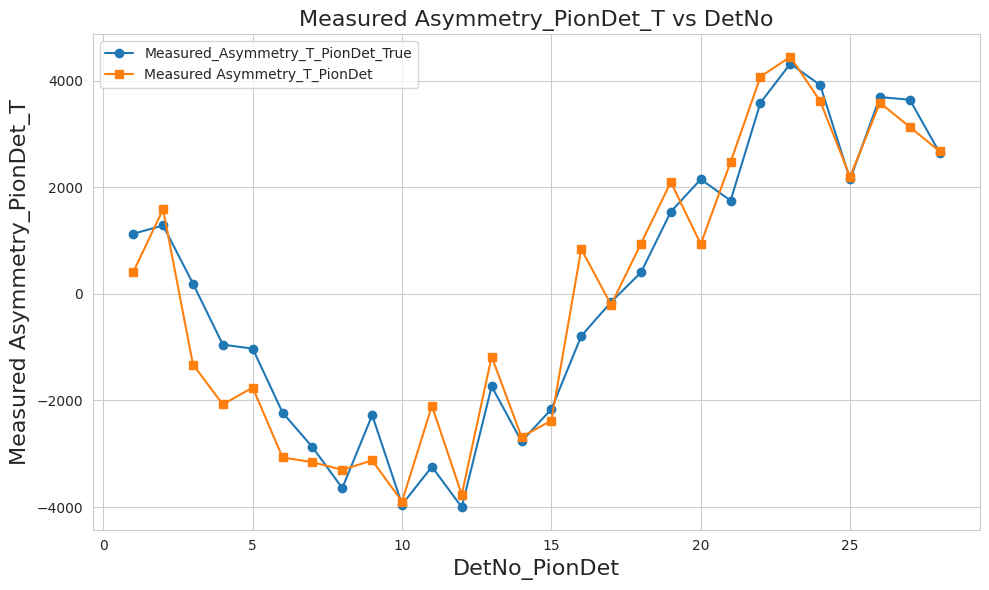

In [ ]:

DetNo_PionDet = np.arange(1, 29)  # This creates an array from 1 to 56

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_PionDet, Measured_Asymmetry_T_PionDet_average_values_True , 'o-', label='Measured_Asymmetry_T_PionDet_True')
plt.plot(DetNo_PionDet, Measured_Asymmetry_T_PionDet_average_values, 's-', label='Measured Asymmetry_T_PionDet')
plt.title('Measured Asymmetry_PionDet_T vs DetNo')
plt.xlabel('DetNo_PionDet')
plt.ylabel('Measured Asymmetry_PionDet_T')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

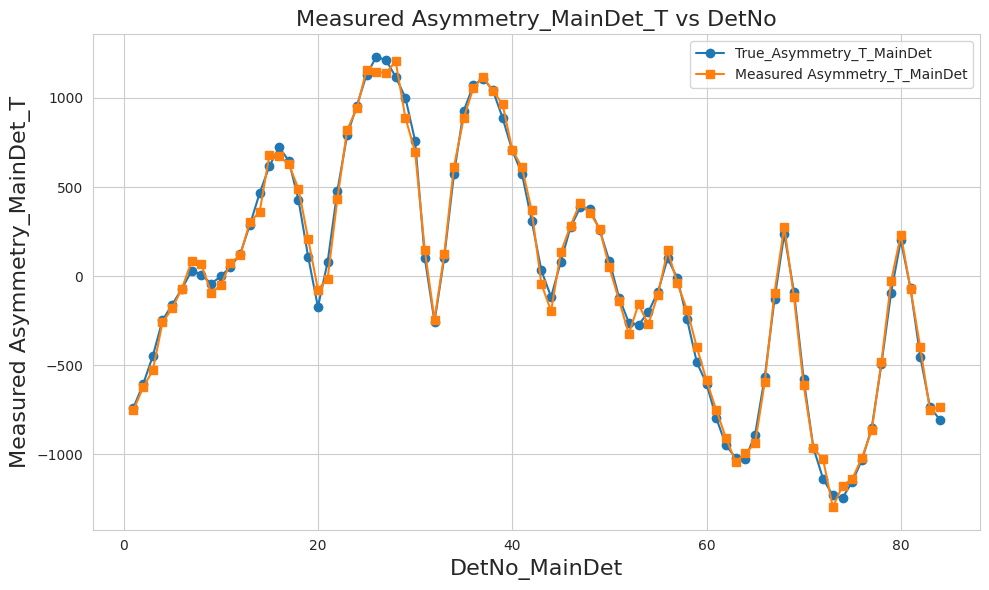

In [ ]:
DetNo_MainDet = np.arange(1, 85)  # This creates an array from 1 to 56

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_MainDet, Measured_Asymmetry_T_MainDet_average_values_True , 'o-', label='True_Asymmetry_T_MainDet')
plt.plot(DetNo_MainDet, Measured_Asymmetry_T_MainDet_average_values, 's-', label='Measured Asymmetry_T_MainDet')
plt.title('Measured Asymmetry_MainDet_T vs DetNo')
plt.xlabel('DetNo_MainDet')
plt.ylabel('Measured Asymmetry_MainDet_T')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Measured_Asymmetry_PionDet = np.concatenate([Measured_Asymmetry_L_PionDet_average_values, Measured_Asymmetry_T_PionDet_average_values])
Measured_Asymmetry_MainDet = np.concatenate([Measured_Asymmetry_L_MainDet_average_values, Measured_Asymmetry_T_MainDet_average_values])
Measured_Asymmetry_PionDet_True = np.concatenate([Measured_Asymmetry_L_PionDet_average_values_True, Measured_Asymmetry_T_PionDet_average_values_True])
Measured_Asymmetry_MainDet_True = np.concatenate([Measured_Asymmetry_L_MainDet_average_values_True, Measured_Asymmetry_T_MainDet_average_values_True])

#print(Measured_Asymmetry_PionDet)
#print(Measured_Asymmetry_PionDet, Measured_Asymmetry_PionDet.shape)

#print(Measured_Asymmetry_MainDet)
#print(Measured_Asymmetry_MainDet, Measured_Asymmetry_MainDet.shape)

#print(Measured_Asymmetry_PionDet_True)
#print(Measured_Asymmetry_PionDet_True, Measured_Asymmetry_PionDet_True.shape)

#print(Measured_Asymmetry_MainDet_True)
#print(Measured_Asymmetry_MainDet_True, Measured_Asymmetry_MainDet_True.shape)

print(Measured_Asymmetry_PionDet.shape, Measured_Asymmetry_MainDet.shape, Measured_Asymmetry_PionDet_True.shape, Measured_Asymmetry_MainDet_True.shape)


(56,) (168,) (56,) (168,)


Data saved to Measured_Asymmetry_PionDet.csv


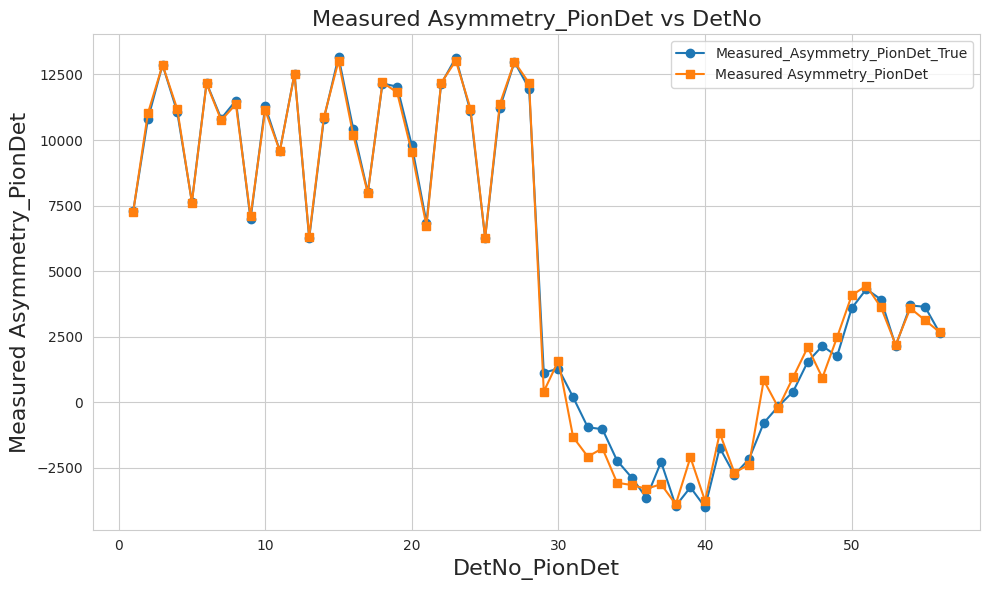

In [ ]:
# Create a DataFrame
df_PionDet = pd.DataFrame(Measured_Asymmetry_PionDet, columns=['Asymmetry_PionDet'])

# Save the DataFrame to a .csv file
df_PionDet.to_csv('Measured_Asymmetry_PionDet.csv', index=False)

print("Data saved to Measured_Asymmetry_PionDet.csv")

DetNo_PionDet = np.arange(1, 57)  # This creates an array from 1 to 56

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_PionDet, Measured_Asymmetry_PionDet_True, 'o-', label='Measured_Asymmetry_PionDet_True')
plt.plot(DetNo_PionDet, Measured_Asymmetry_PionDet, 's-', label='Measured Asymmetry_PionDet')
plt.title('Measured Asymmetry_PionDet vs DetNo')
plt.xlabel('DetNo_PionDet')
plt.ylabel('Measured Asymmetry_PionDet')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Data saved to Measured_Asymmetry_MainDet.csv


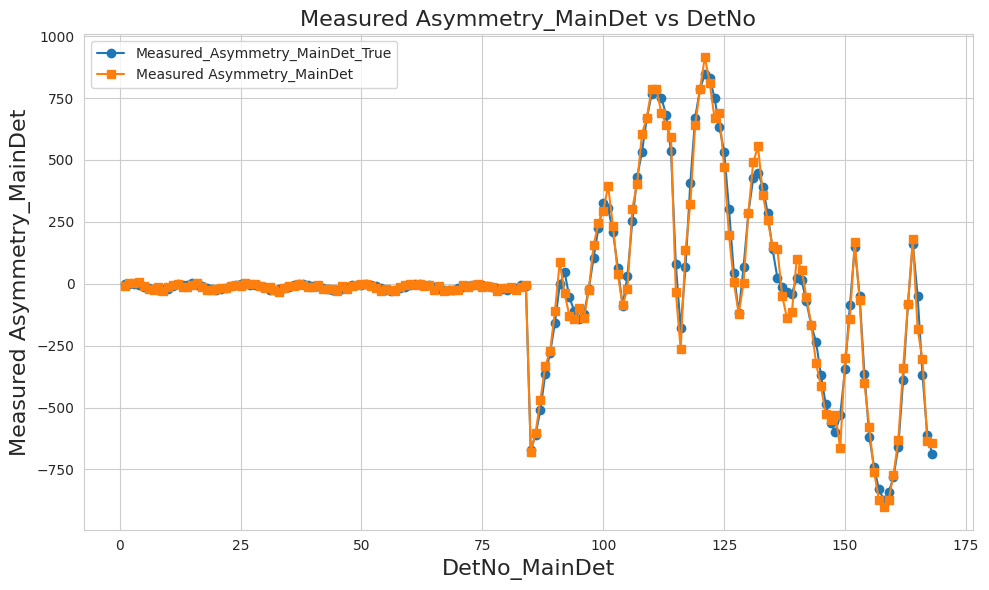

In [ ]:
# Create a DataFrame
df_MainDet = pd.DataFrame(Measured_Asymmetry_MainDet, columns=['Asymmetry_MainDet'])

# Save the DataFrame to a .csv file
df_MainDet.to_csv('Measured_Asymmetry_MainDet.csv', index=False)

print("Data saved to Measured_Asymmetry_MainDet.csv")

DetNo_MainDet = np.arange(1, 169)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(DetNo_MainDet, Measured_Asymmetry_MainDet_True, 'o-', label='Measured_Asymmetry_MainDet_True')
plt.plot(DetNo_MainDet, Measured_Asymmetry_MainDet, 's-', label='Measured Asymmetry_MainDet')
plt.title('Measured Asymmetry_MainDet vs DetNo')
plt.xlabel('DetNo_MainDet')
plt.ylabel('Measured Asymmetry_MainDet')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

